In [1]:
## 20230519 NF/FF Flights with fixed pulsing cadence over WLC... (use WLC Site!)
## Group 1: ch0=Bicolog, ch1=Telescope_Y_NSpol
    ## 'FLY779.csv' - Altitude ~100m, Yaw ~0deg  --> FFNS
    ## 'FLY780.csv' - Altitude ~20m, Yaw ~0deg   --> NFNS20
    ## 'FLY781.csv' - Altitude ~18m, Yaw ~0deg   --> NFNS18
## Group 2: ch0=Telescope_X_EWpol, ch1=Bicolog
    ## 'FLY782.csv' - Altitude ~18m, Yaw ~90deg  --> NFEW18
    ## 'FLY783.csv' - Altitude ~20m, Yaw ~90deg  --> NFEW20
    ## 'FLY784.csv' - Altitude ~100m, Yaw ~90deg --> FFEW
    
## Changelog/Bug hunting notes:
# Solved timing bugs from clockless correlator operation:
    #1) recreated time axis from fpga_counts
    #2) changed WLC site read options to remove factor of 1e-9 on t0

##From loadD3Adata_Dallas.py:
from matplotlib.pyplot import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import numpy as np
import h5py
##From WT:
import datetime
import pytz
import os
import glob
from matplotlib import colors
import pandas
import csv
import pickle
%matplotlib inline
import beamcals
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
from beamcals import beammap
from beamcals import reduce_ccclass
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
import beamcals.reduce_ccclass as rc
from beamcals.sites import site
import yaml
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'


# Display settings:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
fly='533'

f = -1
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]

for fi in range(0,len(documents["flight_info"]["flights"])):
    if fly == flights[fi]: f = fi
print(f, 'FLIGHT: ', documents["flight_info"]["flights"][f])

fly = flights[f]
dtub = documents["flight_info"]["tubs"][f]
dtlb = documents["flight_info"]["tlbs"][f]
cdat = documents["flight_info"]["cdats"][f]
tclb = documents["flight_info"]["tclbs"][f]
tcub = documents["flight_info"]["tcubs"][f]
fmax = documents["flight_info"]["fmaxes"][f]

print(fly,dtlb,dtub,cdat,tclb,tcub,fmax)


0 FLIGHT:  533
533 1900 11000 20210826T182904Z 8500 20000 None


Initializing drone data via datcon_csv routine: FLY533.csv
  --> Skipping rows 1 to 2399 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 9100/9100 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.
plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [0:-1]


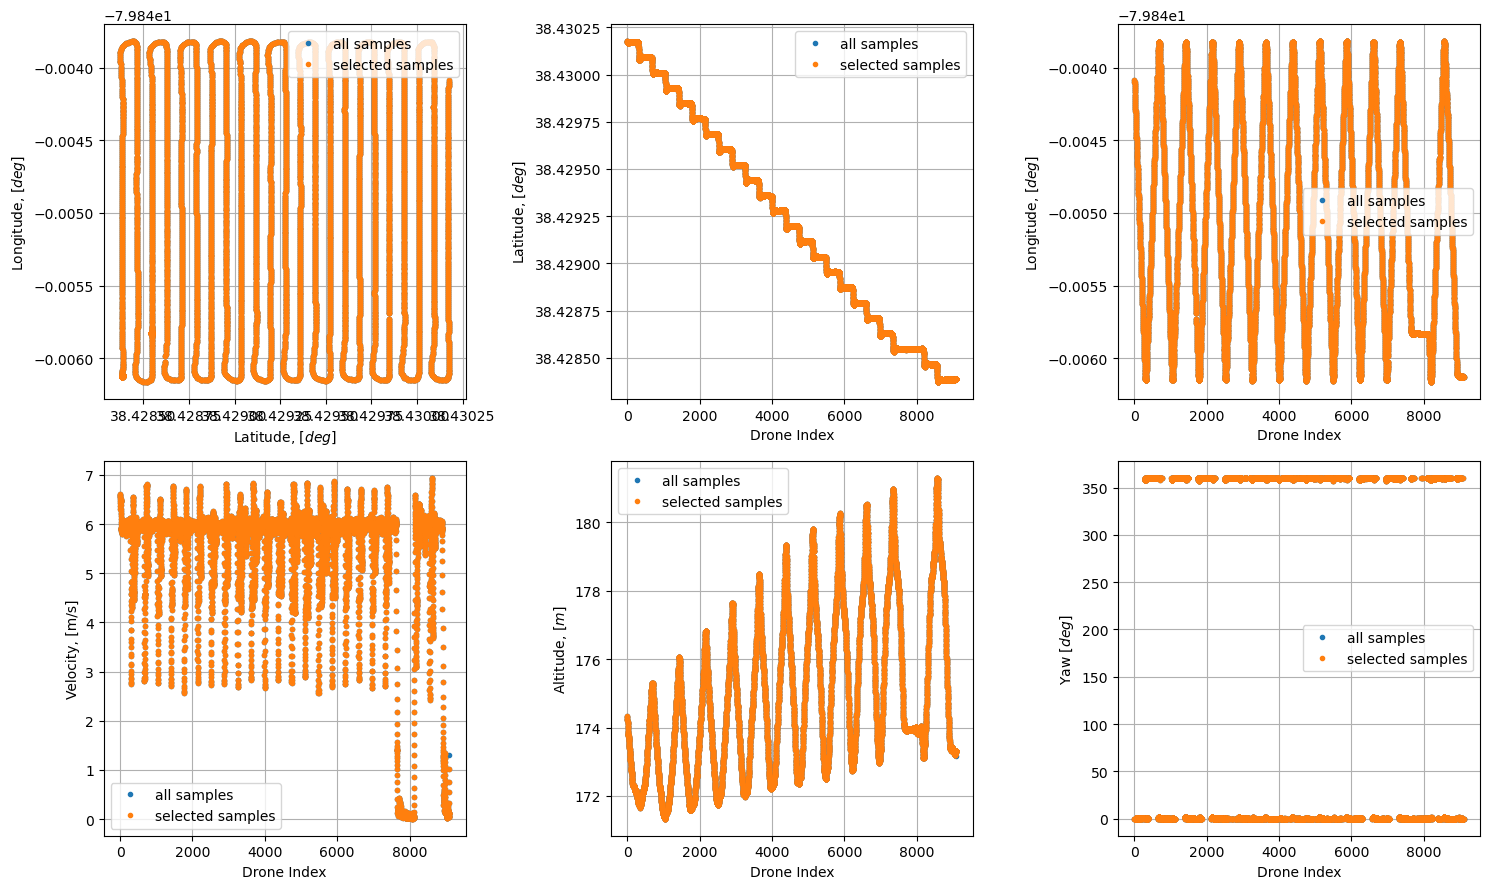

In [3]:
# Flight 1: 'FLY533.csv' 
dronedir='/hirax/all_drone_data/datcon_csv/'
f533drone=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY'+fly+'.csv',site_class=gbosite,tlb=dtlb,tub=dtub)
pu.Plot_Drone_Coordinates(f533drone)

In [4]:
datadir='/hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/'
gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/20210826T182904Z_yale_drone_yale_digitalgain/'
f533corr=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite,crossmap=[])

Initializing Correlator Class using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> Arrays initialized with shape (124, 256, 1024, 16)
Assigning array values by reading in data files:
  --> Loading File: 0123/0123
  --> Finished. Reshaping arrays.


In [5]:
f533concat=concat.CONCAT(CORRDATCLASS=f533corr,DRONEDATCLASS=f533drone,\
                        config_directory="/hirax/GBO_Analysis_Outputs/tynd/concat_config_files/",\
                        output_directory="/hirax/GBO_Analysis_Outputs/tynd/",\
                        load_yaml=False,traceback=True,save_traceback=True)

Initializing CONCAT CLASS with active traceback using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> FLY533.csv
Creating directory for saving traceback and analysis outputs:
  --> /hirax/GBO_Analysis_Outputs/tynd/FLY533_20210826T182904Z_ver_20231010T142152/
Concat initialized without previous config file...
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 21755 elements
  --> drone timestamp axis contains 9100 elements


In [ ]:
f533concat.Extract_Source_Pulses(Period=400000,Dutycycle=200000,t_bounds=[17800,18000],f_ind=900,minmaxpercents=[10.0,99.0])

f533concat.Perform_Background_Subtraction(window_size=5)
f533concat.Synchronization_Function(inputcorr=f533corr,inputdrone=f533drone,freqs=np.arange(700,900,20),\
                                    FMB_coordbounds=[50.0,50.0,100.0],FMB_ampbound=0.999)
# f533concat.Main_Beam_Fitting(fit_param_directory="/hirax/GBO_Analysis_Outputs/tynd/main_beam_fits/",Vargs='bgsub',coordbounds=[20,20,15])
# # FFNSconcat.Export_yaml()

# #export pickle for reduced class data for beammap function (include_cross_data=True will save V_cross_bgsub):
# # thingy = rc.Smallify(concatclass=FFNSconcat,pickle_directory="/home/tyndall/Desktop/20230519_WLC_NF2FF_Flights/products/pickles/",include_cross_data=True)
# # print(thingy.tmppath)
# # with open(thingy.tmppath, 'wb') as outp:
# #     pickle.dump(thingy, outp, pickle.HIGHEST_PROTOCOL)
# # print('DONE')

In [ ]:
## beamcals package EXTRACT SOURCE PULSES FUNCTION: updated and pushed 20230908
stop

    def Extract_Source_Pulses(self,Period=0.4e6,Dutycycle=0.2e6,t_bounds=[0,-1],f_ind=[900],minmaxpercents=[10.0,99.5]):
        ## Search for all three timing variables that must be loaded from config:
        if hasattr(self,"pulse_period")==True and hasattr(self,"pulse_dutycycle")==True and hasattr(self,"t_delta_pulse")==True:
            if self.traceback==True:
                print("Extracting Source Pulses using parameters loaded from config file:")
                print('  --> pulse_period = {}'.format(self.pulse_period))                        
                print('  --> pulse_dutycycle = {}'.format(self.pulse_dutycycle))                        
                print('  --> t_delta_pulse = {}'.format(self.t_delta_pulse))
            if self.traceback==False:
                pass
            concat_duration=int(np.ceil((self.t_arr_datetime[-1]-self.t_arr_datetime[0]).total_seconds()))
            time_s,time_dt,switch=tu.Pulsed_Data_Waveform(total_duration=concat_duration,period=self.pulse_period,duty_cycle_on=self.pulse_dutycycle)
        ## If we don't have any variables, then we haven't loaded a yaml yet... and must run the function:
        if hasattr(self,"t_delta_pulse")==False:
            ## Create Switch Signal
            self.pulse_period=Period
            self.pulse_dutycycle=Dutycycle
            concat_duration=int(np.ceil((self.t_arr_datetime[-1]-self.t_arr_datetime[0]).total_seconds()))
            time_s,time_dt,switch=tu.Pulsed_Data_Waveform(total_duration=concat_duration,period=self.pulse_period,duty_cycle_on=self.pulse_dutycycle)
            ## Create t_offset range (1 period) and Pearson_r vars:
            t_offset_dist=np.arange(-1.0*self.pulse_period*1e-6,0.0,0.001)
            Pr_arr=np.NaN*np.ones((self.n_channels,t_offset_dist.shape[0]))
            Pr_max_ind_per_channel=np.NaN*np.ones(self.n_channels)
            Pr_max_t_0_per_channel=np.NaN*np.ones(self.n_channels)
            t_full=np.array([(m-self.t_arr_datetime[0]).total_seconds() for m in self.t_arr_datetime[:]])
            ## Loop over channels to find/plot a time offset solution with some clever fitting:
            if self.traceback==True:
                fig1,ax1=subplots(nrows=1,ncols=1,figsize=(16,4))
            elif self.traceback==False:
                pass
            for i in range(self.n_channels):
                ## If we use a mean subtracted data cut we can find where power exceeds zero to find signal
                minsubdata=self.V[:,f_ind,i]-np.percentile(self.V[:,f_ind,i],minmaxpercents[0])
                normminsubdata=minsubdata/np.percentile(minsubdata,minmaxpercents[1])
                clipnormminsubdata=normminsubdata.clip(0,1)
                stepped_func=interp1d(t_full,clipnormminsubdata,kind='previous',fill_value='extrapolate')
                sniparr=np.where(time_s[np.where(time_s<=t_full[t_bounds[1]])[0]]>=t_full[t_bounds[0]])[0]
                t_restrict=np.intersect1d(np.arange(len(time_s))[~np.isnan(stepped_func(time_s))],sniparr)
                ## Loop over all time offsets in t_offset_dist to find maximum correlation between squarewave and data:
                for j,t_offset in enumerate(t_offset_dist):
                    shiftedswitch=np.interp(time_s,time_s+t_offset,switch)
                    try:
                        Pr_arr[i,j]=pearsonr(stepped_func(time_s[t_restrict]),shiftedswitch[t_restrict])[0]
                    except ValueError:
                        Pr_arr[i,j]=np.NAN
                if self.traceback==True:
                    ax1.plot(t_offset_dist,Pr_arr[i,:],'.')
                elif self.traceback==False:
                    pass
                try:
                    maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]
                    if self.traceback==True:
                        ax1.plot(t_offset_dist[maxPrind],Pr_arr[i,maxPrind],'ro')
                    elif self.traceback==False:
                        pass
                    Pr_max_ind_per_channel[i]=maxPrind
                    Pr_max_t_0_per_channel[i]=t_offset_dist[maxPrind]
                except IndexError:
                    Pr_max_ind_per_channel[i]=np.NAN
                    Pr_max_t_0_per_channel[i]=np.NAN            
            self.t_delta_pulse=np.nanmedian(Pr_max_t_0_per_channel)
            if self.traceback==True:
                ax1.axvline(self.t_delta_pulse,label="selected t_offset")
                ax1.legend(loc=1)
                tight_layout()
                print("Maximum Pearson_R Correlations between data and square wave function:") 
                print("  --> t_indices = {}".format(Pr_max_ind_per_channel))
                print("  --> t_deltas = {}".format(np.around(Pr_max_t_0_per_channel,decimals=3)))
                print("Selecting square wave function time offset:")
                print("  --> t_delta_pulse = {:.10f}".format(self.t_delta_pulse))
                if self.save_traceback==True:
                    savefig(self.Output_Directory+self.Output_Prefix+"_t_delta_pulse_Pearson_R.png")
                if self.save_traceback==False:
                    pass
            elif self.traceback==False:
                pass
        ## Interpolate the switching function with the concat timestamps using either input or found t_delta_pulse:
        t_for_interp_out=t_full
        t_for_interp_in=np.array([m.total_seconds() for m in time_dt])
        switch_interp_f=np.interp(t_for_interp_out,t_for_interp_in+self.t_delta_pulse,switch)
        self.switch_signal=switch
        self.switch_time=t_for_interp_in
        self.switch_signal_interp=switch_interp_f
        ## Once we have our time offset, we must extract indices where the source is on/off/rising:
        self.inds_span=np.union1d(list(set(np.where(np.diff(np.sign(switch_interp_f-0.5)))[0])),\
                                  np.intersect1d(np.where(1.0>switch_interp_f),np.where(switch_interp_f>0.0))).tolist()
        self.inds_on=list(set(np.where(switch_interp_f==1.0)[0])-set(self.inds_span))
        self.inds_off=list(set(np.where(switch_interp_f==0.0)[0])-set(self.inds_span))
        ## Each of these lists of indices should also have no overlap. Let's print to see:
        if self.traceback==True:
            print("Finding relevant pulsing indices and checking for overlaps:")        
            print("  --> on/off ind intersection:",np.intersect1d(self.inds_on,self.inds_off))
            print("  --> on/span ind intersection:",np.intersect1d(self.inds_on,self.inds_span))
            print("  --> off/span ind intersection:",np.intersect1d(self.inds_off,self.inds_span))
            ## Let's plot the on/off/rising index groups:
            fig3=figure(figsize=(16,int(4*self.n_channels/2)))
            for i in range(self.n_channels):
                ax=fig3.add_subplot(int(self.n_channels/2),2,i+1)   
                ax.semilogy(self.t_arr_datetime[:],self.V[:,f_ind,i],'k.',label='all')
                ax.semilogy(self.t_arr_datetime[self.inds_on],self.V[self.inds_on,f_ind,i],'.',label='on')
                ax.semilogy(self.t_arr_datetime[self.inds_off],self.V[self.inds_off,f_ind,i],'.',label='off')   
                ax.semilogy(self.t_arr_datetime[self.inds_span],self.V[self.inds_span,f_ind,i],'x',label='span')
                ax.semilogy(self.t_arr_datetime[:],(np.nanmax(self.V[self.inds_on,f_ind,i])*switch_interp_f)+np.nanmin(self.V[self.inds_on,f_ind,i]),'--',alpha=0.1,label='switch, t_offset={:.2f}'.format(self.t_delta_pulse))
                ax.set_ylabel("Log Power Received [$ADU^2$]")
                ax.set_xlabel("Datetime")
                ax.set_title("Channel {}".format(self.chmap[i]))
                ax.legend(loc=2)
                ax.set_xlim(self.t_arr_datetime[t_bounds[0]],self.t_arr_datetime[t_bounds[1]])
            tight_layout()
            if self.save_traceback==True:
                savefig(self.Output_Directory+self.Output_Prefix+"_t_delta_pulse_index_solution.png")
            if self.save_traceback==False:
                pass            
        if self.traceback==False:
            pass
